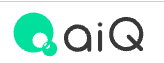

[disclaimer](../../disclaimer.txt/)

# aiQ DataHub: aiQ POS ELEC Goods Sample Evaluation Notebook

- aiQ POS Elec Goods is data that consolidates the sales of electronic products from electronics retailers and online shopping platforms, organized by TICKER.

In [1]:
# Evaluate the following command to update the custom module
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.io
import plotly.express as px
from aiq_strategy_robot.data.data_accessor import DAL

In [3]:
if '../..' not in sys.path:
    sys.path.append('../..')
    
from libs.dataset import aiq_pos_elec_goods as sc_elec
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [4]:
sdh = DAL()

## Step 2: Load Data to `sdh`
Since the focus here is on demonstrating data analysis, the data will be loaded through a simple loader that has been prepared separately.

In [5]:
sdh.extract.clear()

data_id_alt = sc_elec.register_elec_goods_data(sdh, data_dir=DEFAULT_DIR)
data_id_mkt = sc_common.register_market(sdh, 'elec_goods')
data_id_funda = sc_common.register_fundamental(sdh)
display(sdh.extract_definition)

category data_source   source    table                          alias  \
data_id                                                                         
1        RawData    external   sample  Unknown                 pos_elec_goods   
2        RawData    External  Unknown  Unknown  market_returns for elec_goods   
3        RawData    External  Unknown  Unknown                          funda   

                                                   tickers  \
data_id                                                      
1        [1956, 2180, 2321, 2323, 2326, 2354, 2388, 246...   
2        [1956, 2180, 2321, 2323, 2326, 2354, 2388, 246...   
3        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [TICKER, DATETIME]  2009-01-01 00:00:00  2024-09-30 00:00:00  
2        [TICKER, DATETIME]  2000-01-04 00:00:00  2024-10-29 00:00:00  
3        [TICKER, DATETIME]  2007-04-20 00:00:00  2024-05-31 00:00:00

### Step 2.1: Identify Tickers with Consistently Available Daily Data
Identify TICKERs where `pos_sales` data is densely observed along the `datetime` axis, with a data density of at least the specified `lower_bound` ratio.

In [6]:
variable = 'pos_sales'
lower_bound = 0.9
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2023-12-31')

In [7]:
# Retrieve the pre-processed data that was registered in the standard data handler.
dfpos = sdh.get_raw_data(data_id_alt)

# Set the index to be a `DatetimeIndex` type with only the `DATETIME` column.
dfcheck = dfpos[[variable]].unstack('TICKER').droplevel(0, axis=1)
if start_date:
    dfcheck = dfcheck.loc[dfcheck.index > start_date]
if end_date:
    dfcheck = dfcheck.loc[dfcheck.index < end_date]
dfcheck.dropna(how='all', axis=1, inplace=True)

# Count the total number of dates.
num_obs = len(dfcheck)

# Count the number of non-NaN rows for each TICKER.
dfcount = dfcheck.count()

# Calculate the percentage of non-NaN rows for each TICKER.
list_dense_tickers = dfcount.loc[dfcount / num_obs > lower_bound].index.tolist()

print(f'Tickers with observations for more than {lower_bound *  100}% of datetime after {start_date}.')
print(f'number of densely observed tickers: {len(list_dense_tickers)}')

Tickers with observations for more than 90.0% of datetime after 2020-01-01 00:00:00.
number of densely observed tickers: 70


### Verify that the data has been successfully registered in `sdh`.

In [8]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_funda).tail())
display(sdh.get_raw_data(data_id_mkt).tail())

VARIABLE           pos_sales     share  unit_price  unit_price_vs_ind
TICKER DATETIME                                                      
9928   2023-10-26   0.003900  0.000422    0.130007           0.107093
       2023-12-22   0.016121  0.002433    0.537438           0.328411
       2024-01-31   0.016121  0.002665    0.537438           0.405101
       2024-08-19   0.016481  0.005209    0.274710           0.208357
       2024-08-24   0.016121  0.006516    0.537438           0.469152

sales_yoy
TICKER DATETIME             
9997   2023-03-31   0.008141
       2023-06-30  -0.030340
       2023-09-30  -0.024041
       2023-12-31  -0.024655
       2024-03-31   0.001886

returns  returns_oo  returns_id  returns_on
TICKER DATETIME                                                
9928   2024-10-21 -0.011275   -0.015890   -0.011275    0.000000
       2024-10-22 -0.026814   -0.008041   -0.030049    0.003235
       2024-10-23 -0.013401   -0.030049   -0.013401    0.000000
       2024-10-24  0.003367   -0.016779    0.006745   -0.003378
       2024-10-25  0.002238    0.007305    0.001678    0.000560

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [9]:
USE_MY_FUNDA = False 

> If you want to use your own market data with the handler, please set the following flag to True. <br> Note that the sample market data has already been adjusted for Returns.

In [10]:
USE_MY_MKT = False 

## Step 3: Correlation Analysis
Given the nature of aiQ POS Elec Goods data, it is expected that it should show some correlation with financial data (quarterly sales).

Here, we will test this hypothesis to determine its validity.

#### Use `AltDataEvaluator` to evaluate the alternative data.

In [11]:
from aiq_strategy_robot.evaluator import AltDataEvaluator
ade = AltDataEvaluator(sdh)

#### Compare the Quarterly Sales Data Loaded in Step 2 with the `pos_sales` from POS Elec Goods
- To enable comparison between the quarterly sales data and `pos_sales`, resample the latter.

In [12]:
sdh.transform.clear()
funda_Q_defs = sdh.transform.resample(data_id=data_id_funda, rule='Q', func='last').variables
alt_Q_defs = sdh.transform.resample(data_id=data_id_alt, rule='Q', func='mean').variables
features = list(sdh.get_raw_data(data_id_alt).columns)

## Step 3.1: Plotting with Quarterly Sales

Plot the quarterly sales data alongside the alternative data to visually inspect the data shapes.
> It is recommended to compare with your financial data before applying YoY adjustments.

#### Create Variables from the Base `variable` and Visually Identify Which Matches the Financial Data
- By using `sdh.transform`, you can create various variables and quickly evaluate which one has the strongest relationship with the financial data.
- For a list of `transform` processes, please refer to the sample notebook provided with the `data handler`.

In [13]:
# サンプルの TICKER を選びます。
sample_target = "7984"

if USE_MY_FUNDA:
    
    # Plot the data to visually inspect its shape.
    sdh.show_line_one_target(
        target=sample_target, # Decide which TICKER's data to plot.
        y=funda_Q_defs.index[0], # Specify the data to be displayed on the y-axis using the `variable_id`.
        X=alt_Q_defs.index, # Specify the data to be displayed on the x-axis using a list of `variable_id`s (use a list when displaying multiple graphs simultaneously).
        col_num=2, # Decide how many graphs to display in a single row.
        vname_len_limit=50, # The title will display the variable names of the X `variable_id`s, but you can specify a character limit to shorten the display.
    )
    
    # First, define the variables.
    vid_alt = sdh.transform.raw(data_id=data_id_alt).variable_ids
    alt_Q_shift_xx_defs = sdh.transform.shift(fields=vid_alt, periods=[0, 3, 4, 5, 6 ,7 ,8, 9, 12]).resample(rule='Q', func='mean').variables

    # Plot the variables created above to visually inspect them.
    sdh.show_line_one_target(
        target=sample_target,
        y=funda_Q_defs.index[0],
        X=[alt_Q_shift_xx_defs.index[4], alt_Q_shift_xx_defs.index[8],
           alt_Q_shift_xx_defs.index[12], alt_Q_shift_xx_defs.index[16], 
           alt_Q_shift_xx_defs.index[20], alt_Q_shift_xx_defs.index[24],
           alt_Q_shift_xx_defs.index[28], alt_Q_shift_xx_defs.index[32], 
           alt_Q_shift_xx_defs.index[36], alt_Q_shift_xx_defs.index[40], 
           alt_Q_shift_xx_defs.index[44], alt_Q_shift_xx_defs.index[48], 
           alt_Q_shift_xx_defs.index[52], alt_Q_shift_xx_defs.index[56],
           alt_Q_shift_xx_defs.index[76], alt_Q_shift_xx_defs.index[80]],
        col_num=2
    )

    # For the next step, calculate the year-over-year (YoY) change and create a variable with an additional lagged difference to address cases where trends might cause apparent correlations.
    sales_defs                        = sdh.transform.log_diff(fields=funda_Q_defs.index, periods=4).variables
    sales_diff_defs                   = sdh.transform.log_diff(fields=funda_Q_defs.index, periods=4).diff(periods=1).variables
    


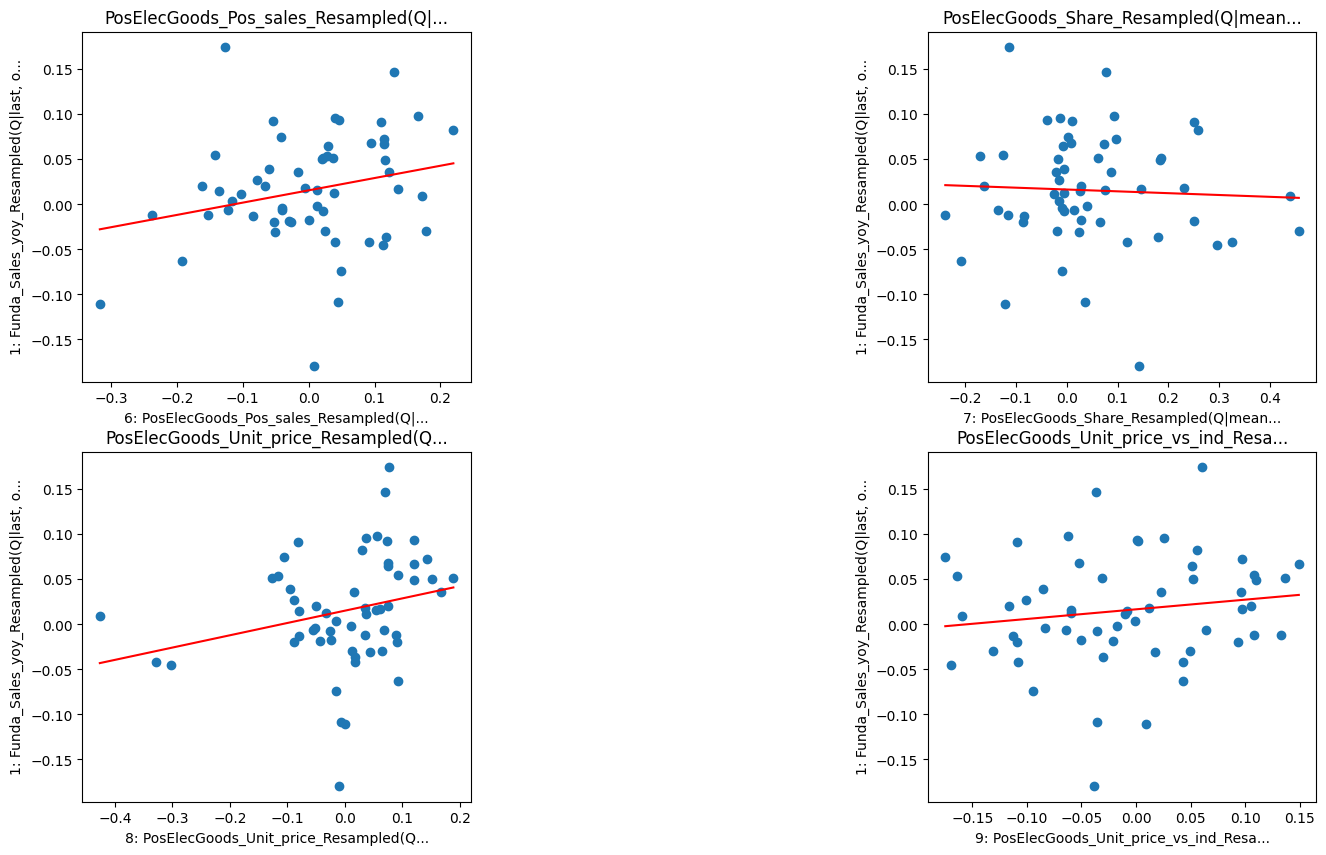

In [14]:
if not USE_MY_FUNDA:

    # Convert the POS data to YoY as well for comparison with the financial data.
    alt_Q_yoy_defs = sdh.transform.log_diff(periods=4, fields=alt_Q_defs.index).variables

    # Plot the data to visually inspect its shape.
    sdh.show_scatter_one_target(
        target=sample_target,
        y=funda_Q_defs.index[0],
        X=alt_Q_yoy_defs.index,
        col_num=2,
        vname_len_limit=35
    )

    # Define the variables.
    # vid_alt = sdh.transform.raw(data_id=data_id_alt).variable_ids
    alt_Q_shift_xx_defs = sdh.transform.shift(data_id=data_id_alt, periods=[0, 3, 4, 5, 6, 7, 8, 9, 12]).resample(rule='Q', func='mean').variables

    # To address cases where trends might cause apparent correlations, create a variable with an additional lagged difference.
    sales_defs = funda_Q_defs
    sales_diff_defs = sdh.transform.diff(fields=funda_Q_defs.index, periods=1).variables
    

In [15]:
# Convert the data to year-over-year (YoY) changes and then calculate the correlation coefficients between sales and the alternative data.
alt_Q_shift_xx_logdiff_defs      = sdh.transform.log_diff(fields=alt_Q_shift_xx_defs.index, periods=4).variables

# To address cases where trends might cause apparent correlations, also create variables with an additional lagged difference.
alt_Q_shift_xx_logdiff_diff_defs = sdh.transform.log_diff(fields=alt_Q_shift_xx_defs.index, periods=4).diff(periods=1).variables

display(alt_Q_shift_xx_logdiff_defs.head())
display(alt_Q_shift_xx_logdiff_diff_defs.head())

variable_id  data_id  \
variable_name                                                              
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...           83        1   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...           84        1   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...           85        1   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...           86        1   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...           87        1   

                                                           root_field  \
variable_name                                                           
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...          pos_sales   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...              share   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...         unit_price   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...          pos_sales   

                                                   return_type other_roots  \
variable_name                                                                
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...           -           -   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...           -           -   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...           -           -   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...           -           -   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...           -           -   

                                                            step_001  \
variable_name                                                          
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  shift(periods=0)   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  shift(periods=0)   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  shift(periods=0)   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...  shift(periods=3)   

                                                                                             step_002  \
variable_name                                                                                           
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...  resample(rule="Q", func="mean", origin="start_...   

                                                               step_003  
variable_name                                                            
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  log_diff(periods=4)  
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  log_diff(periods=4)  
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  log_diff(periods=4)  
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  log_diff(periods=4)  
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...  log_diff(periods=4)

variable_id  data_id  \
variable_name                                                              
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...          119        1   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...          120        1   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...          121        1   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...          122        1   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...          123        1   

                                                           root_field  \
variable_name                                                           
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...          pos_sales   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...              share   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...         unit_price   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...          pos_sales   

                                                   return_type other_roots  \
variable_name                                                                
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...           -           -   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...           -           -   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...           -           -   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...           -           -   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...           -           -   

                                                            step_001  \
variable_name                                                          
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  shift(periods=0)   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  shift(periods=0)   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  shift(periods=0)   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...  shift(periods=3)   

                                                                                             step_002  \
variable_name                                                                                           
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...  resample(rule="Q", func="mean", origin="start_...   

                                                               step_003  \
variable_name                                                             
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  log_diff(periods=4)   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  log_diff(periods=4)   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  log_diff(periods=4)   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  log_diff(periods=4)   
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...  log_diff(periods=4)   

                                                           step_004  
variable_name                                                        
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  diff(periods=1)  
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  diff(periods=1)  
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  diff(periods=1)  
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  diff(periods=1)  
PosElecGoods_Pos_sales_Shifted(003)_Resampled(Q...  diff(periods=1)

#### Correlation Calculation

In [16]:
rho_pool_by_logdiff = ade.compu_rho_by_df(alt_Q_shift_xx_logdiff_defs, sales_defs, 'step_001')
display(rho_pool_by_logdiff.xs('t-val', level=1).sort_values(rho_pool_by_logdiff.columns[0], ascending=False))

rho_pool_by_logdiff_diff = ade.compu_rho_by_df(alt_Q_shift_xx_logdiff_diff_defs, sales_diff_defs, 'step_001')
display(rho_pool_by_logdiff_diff.xs('t-val', level=1).sort_values(rho_pool_by_logdiff_diff.columns[0], ascending=False))

shift(periods=0)  shift(periods=3)  shift(periods=4)  \
pos_sales                  3.233176          2.825524          3.196123   
unit_price                 2.904919          2.440724          2.989713   
unit_price_vs_ind          0.002885         -0.899237         -0.357541   
share                     -0.621987         -1.466537         -0.416439   

                   shift(periods=5)  shift(periods=6)  shift(periods=7)  \
pos_sales                  2.973912          2.480884          2.570647   
unit_price                 2.683163          2.318238          2.048981   
unit_price_vs_ind         -0.387374         -0.321360         -0.321266   
share                     -0.884695         -0.826998         -0.833733   

                   shift(periods=8)  shift(periods=9)  shift(periods=12)  
pos_sales                  2.718835          2.496301           2.816728  
unit_price                 2.646824          2.342579           2.573875  
unit_price_vs_ind         -0.179232         -0.018214          -0.360682  
share                     -1.388605         -1.158141          -1.085433

shift(periods=0)  shift(periods=3)  shift(periods=4)  \
pos_sales                  4.649395          4.535615          4.827031   
unit_price                 4.170010          4.052227          4.366614   
unit_price_vs_ind          0.747075          0.444205          1.236975   
share                     -0.050049         -0.259693          0.157461   

                   shift(periods=5)  shift(periods=6)  shift(periods=7)  \
pos_sales                  3.990994          3.961458          4.116617   
unit_price                 3.678331          4.105027          3.901618   
unit_price_vs_ind          1.465652          2.054934          1.580063   
share                     -1.003414         -0.362417         -0.105828   

                   shift(periods=8)  shift(periods=9)  shift(periods=12)  
pos_sales                  3.170040          2.993365           3.960483  
unit_price                 3.646083          3.554837           5.629910  
unit_price_vs_ind          0.594106          0.362401           0.940526  
share                     -1.357434         -1.602394          -0.854274

- Since `pos_sales` and `unit_price` are found to have a high correlation with the financial data, create a new variable that is the product of these two.

In [17]:
combo_feature = "sales*uprice"

sales_and_uprice_defs = sdh.transform.mul(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name=combo_feature).variables
alt_raw_defs = pd.concat([sdh.transform.raw(data_id=data_id_alt).variables, sales_and_uprice_defs])

alt_Q_shift_xx_defs = sdh.transform.shift(fields=alt_raw_defs.index, periods=[0, 3, 4, 5, 6, 7, 8, 9, 12]).resample(rule='Q', func='mean').variables

# Convert the data to year-over-year (YoY) changes and then calculate the correlation coefficients between sales and the alternative data.
alt_Q_shift_xx_logdiff_defs      = sdh.transform.log_diff(fields=alt_Q_shift_xx_defs.index, periods=4).variables

# To address cases where trends might cause apparent correlations, also create variables with an additional lagged difference.
alt_Q_shift_xx_logdiff_diff_defs = sdh.transform.log_diff(fields=alt_Q_shift_xx_defs.index, periods=4).diff(periods=1).variables

display(alt_Q_shift_xx_logdiff_defs.head())
display(alt_Q_shift_xx_logdiff_diff_defs.head())

variable_id  data_id  \
variable_name                                                              
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...           83        1   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...           84        1   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...           85        1   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...           86        1   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...          178        1   

                                                           root_field  \
variable_name                                                           
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...          pos_sales   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...              share   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...         unit_price   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...          pos_sales   

                                                   return_type    other_roots  \
variable_name                                                                   
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...           -              -   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...           -              -   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...           -              -   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...           -              -   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...           -  [1]unit_price   

                                                   step_001  \
variable_name                                                 
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...        -   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...        -   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...        -   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...        -   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...    raw()   

                                                                                step_002  \
variable_name                                                                              
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...                                     -   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...                                     -   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...                                     -   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...                                     -   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...  mul(x2field=PosElecGoods_Unit_price)   

                                                            step_003  \
variable_name                                                          
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  shift(periods=0)   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  shift(periods=0)   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  shift(periods=0)   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...  shift(periods=0)   

                                                                                             step_004  \
variable_name                                                                                           
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample(rule="Q", func="mean", origin="start_...   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...  resample(rule="Q", func="mean", origin="start_...   

                                                               step_005  
variable_name                        

variable_id  data_id  \
variable_name                                                              
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...          119        1   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...          120        1   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...          121        1   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...          122        1   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...          187        1   

                                                           root_field  \
variable_name                                                           
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...          pos_sales   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...              share   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...         unit_price   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  unit_price_vs_ind   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...          pos_sales   

                                                   return_type    other_roots  \
variable_name                                                                   
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...           -              -   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...           -              -   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...           -              -   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...           -              -   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...           -  [1]unit_price   

                                                   step_001  \
variable_name                                                 
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...        -   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...        -   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...        -   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...        -   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...    raw()   

                                                                                step_002  \
variable_name                                                                              
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...                                     -   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...                                     -   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...                                     -   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...                                     -   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...  mul(x2field=PosElecGoods_Unit_price)   

                                                            step_003  \
variable_name                                                          
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  shift(periods=0)   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  shift(periods=0)   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  shift(periods=0)   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  shift(periods=0)   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...  shift(periods=0)   

                                                                                             step_004  \
variable_name                                                                                           
PosElecGoods_Pos_sales_Shifted(000)_Resampled(Q...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Share_Shifted(000)_Resampled(Q|mea...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Unit_price_Shifted(000)_Resampled(...  resample(rule="Q", func="mean", origin="start_...   
PosElecGoods_Unit_price_vs_ind_Shifted(000)_Res...  resample(rule="Q", func="mean", origin="start_...   
sales*uprice_Shifted(000)_Resampled(Q|mean, ori...  resample(rule="Q", func="mean", origin="start_...   

                                                               step_005  \
variable_name                       

In [18]:
rho_pool_by_logdiff = ade.compu_rho_by_df(alt_Q_shift_xx_logdiff_defs, sales_defs, 'step_003')
display(rho_pool_by_logdiff.xs('t-val', level=1).sort_values(rho_pool_by_logdiff.columns[0], ascending=False))

rho_pool_by_logdiff_diff = ade.compu_rho_by_df(alt_Q_shift_xx_logdiff_diff_defs, sales_diff_defs, ['step_003', 'step_006'])
display(rho_pool_by_logdiff_diff.xs('t-val', level=1).sort_values(rho_pool_by_logdiff_diff.columns[0], ascending=False))

shift(periods=0)  shift(periods=3)  shift(periods=4)  \
pos_sales*[1]unit_price          4.422475          3.870997          4.159324   
pos_sales                        3.233176          2.825524          3.196123   
unit_price                       2.904919          2.440724          2.989713   
unit_price_vs_ind                0.002885         -0.899237         -0.357541   
share                           -0.621987         -1.466537         -0.416439   

                         shift(periods=5)  shift(periods=6)  shift(periods=7)  \
pos_sales*[1]unit_price          3.880284          3.624087          3.615510   
pos_sales                        2.973912          2.480884          2.570647   
unit_price                       2.683163          2.318238          2.048981   
unit_price_vs_ind               -0.387374         -0.321360         -0.321266   
share                           -0.884695         -0.826998         -0.833733   

                         shift(periods=8)  shift(periods=9)  shift(periods=12)  
pos_sales*[1]unit_price          3.746341          3.365738           3.947575  
pos_sales                        2.718835          2.496301           2.816728  
unit_price                       2.646824          2.342579           2.573875  
unit_price_vs_ind               -0.179232         -0.018214          -0.360682  
share                           -1.388605         -1.158141          -1.085433

shift(periods=0) shift(periods=3) shift(periods=4)  \
                         diff(periods=1)  diff(periods=1)  diff(periods=1)   
pos_sales*[1]unit_price         6.074569         5.719615         5.655615   
pos_sales                       4.649395         4.535615         4.827031   
unit_price                      4.170010         4.052227         4.366614   
unit_price_vs_ind               0.747075         0.444205         1.236975   
share                          -0.050049        -0.259693         0.157461   

                        shift(periods=5) shift(periods=6) shift(periods=7)  \
                         diff(periods=1)  diff(periods=1)  diff(periods=1)   
pos_sales*[1]unit_price         5.044998         4.764184         4.936769   
pos_sales                       3.990994         3.961458         4.116617   
unit_price                      3.678331         4.105027         3.901618   
unit_price_vs_ind               1.465652         2.054934         1.580063   
share                          -1.003414        -0.362417        -0.105828   

                        shift(periods=8) shift(periods=9) shift(periods=12)  
                         diff(periods=1)  diff(periods=1)   diff(periods=1)  
pos_sales*[1]unit_price         4.363944         4.160019          5.539937  
pos_sales                       3.170040         2.993365          3.960483  
unit_price                      3.646083         3.554837          5.629910  
unit_price_vs_ind               0.594106         0.362401          0.940526  
share                          -1.357434        -1.602394         -0.854274

##### Correlation values can also be calculated on a Ticker-by-Ticker basis
- Below, the top 5 TICKERs are selected, and their relationships are plotted.

In [19]:
alt_Q_shift_06_logdiff_diff_defs = sdh.transform.search_applied_methods(alt_Q_shift_xx_logdiff_diff_defs, {'step_003': 'shift(periods=6)'})
# alt_Q_shift_06_logdiff_diff_defs

In [20]:
rho_time = ade.compu_rho(
    alt_Q_shift_06_logdiff_diff_defs.index,
    sales_diff_defs.iloc[0].name, by='TICKER',
    rename_features=features + ['sales*uprice'],
    min_nsample=30
)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


pos_sales     share  unit_price  unit_price_vs_ind  sales*uprice
TICKER                                                                  
6676     5.843781  0.975900    2.331842           0.078864      4.376457
6955     4.512744  4.347149    1.978712           1.863809      5.201449
6930     4.172701  1.238276    0.525223           0.281991      3.407847
7733     3.093917  0.029635    1.038398          -1.930900      2.642756
7962     3.091351  2.582110    1.824859           1.416967      2.439840

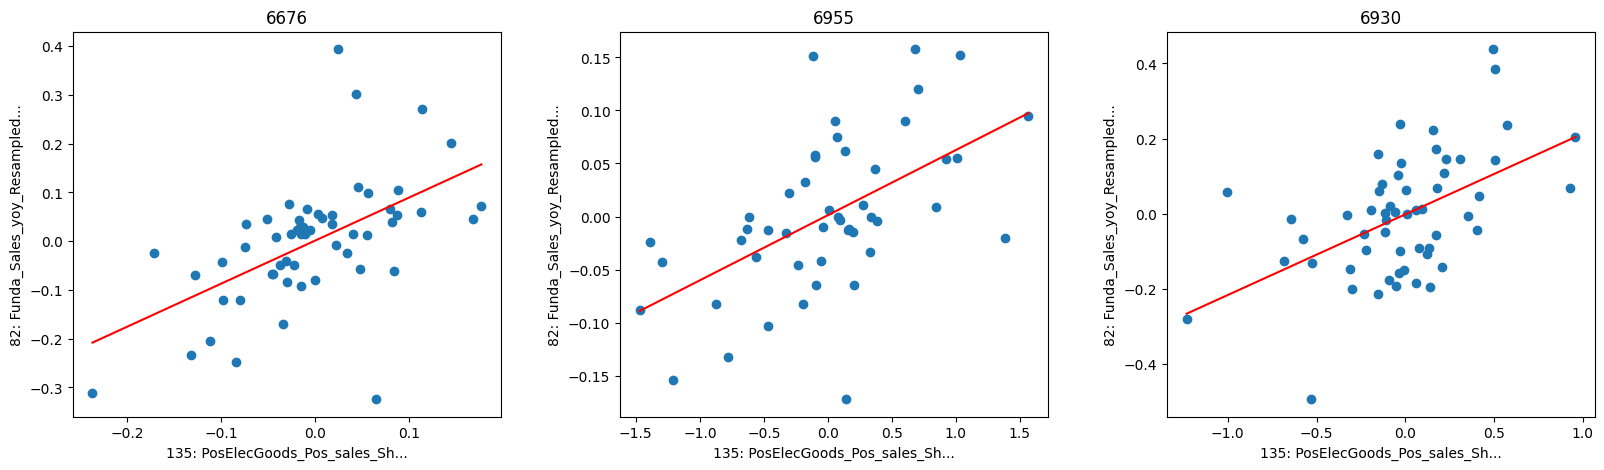

In [21]:
top3tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:3]

sdh.show_scatter_per_target(
    y=sales_diff_defs.iloc[0].name,
    x=alt_Q_shift_06_logdiff_diff_defs.index[0],
    targets=top3tickers,
    col_num=3,
    vname_len_limit=25,
)

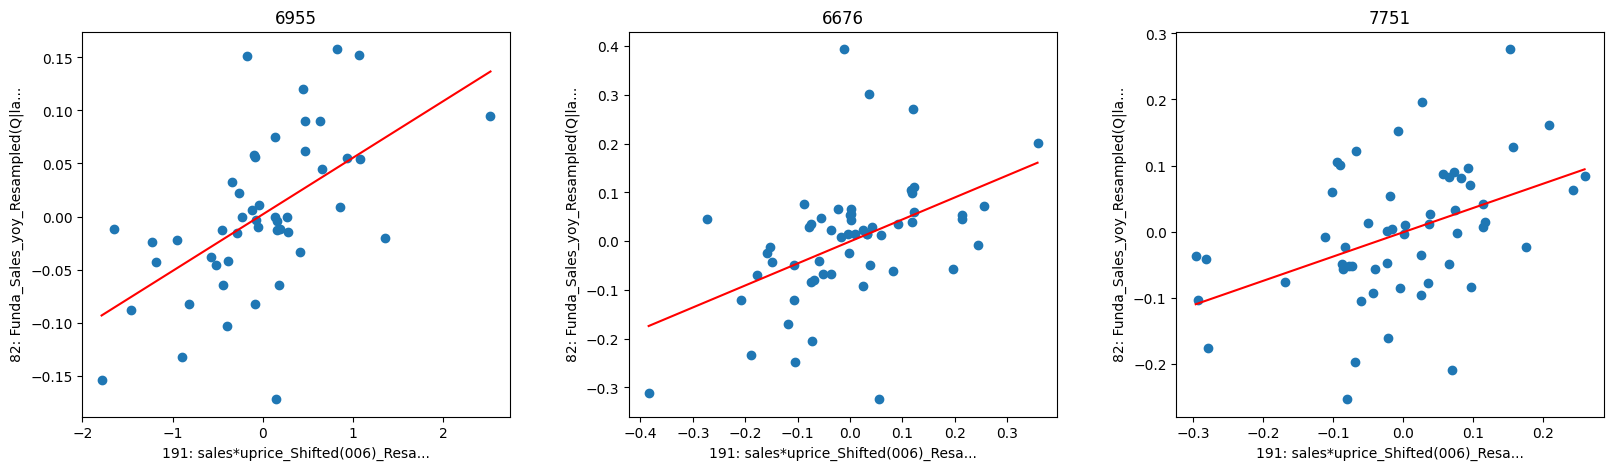

In [22]:
top3tickers = rho_time.T.xs('t-val', level=1).sort_values('sales*uprice', ascending=False).index[:3]

sdh.show_scatter_per_target(
    y=sales_diff_defs.iloc[0].name,
    x=alt_Q_shift_06_logdiff_diff_defs.index[-1],
    targets=top3tickers,
    col_num=3,
    vname_len_limit=30,
)

## Step 4: Quantile Backtest
- Based on the variables created in Step 3, various factors will be generated and calculations will be performed.
- Here, the 2-week moving average of the `sales*uprice` variable is selected as the factor value.
- In practice, you should vary hyperparameters such as the moving average period and shift intervals to ensure that the backtest results are not significantly affected.

In [23]:
sdh.transform.clear()
if USE_MY_MKT:
    close_ret = sdh.transform\
        .resample(data_id=data_id_mkt, rule='D', fields='close', func='last')\
        .dropna(how='all')\
        .calc_return(name='ret')\
        .variables
else:
    close_ret = sdh.transform.cumsum(data_id=data_id_mkt, fields='returns').exp().calc_return(name='ret').variables

In [24]:
sma_period = 14
min_period = int(max(np.floor(sma_period * 5 / 7), 1))

In [25]:
feature1 = sdh.transform\
        .resample(rule='D', func='last', data_id=data_id_alt, fields='pos_sales')\
        .sma(periods=sma_period, min_periods=min_period)\
        .reindex(label=close_ret.index[0])\
        .log_diff(periods=252)\
        .shift(periods=8)\
        .variables

feature2 = sdh.transform\
        .mul(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price")\
        .resample(rule='D', func='last')\
        .sma(periods=sma_period, min_periods=min_period)\
        .reindex(label=close_ret.index[0])\
        .log_diff(periods=252)\
        .shift(periods=8)\
        .variables

In [26]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

### Try pos_sales factor

In [27]:
close_ret.index[0]

'ret'

In [28]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature=feature1.index[0],
    actual_return=close_ret.index[0],
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  \
001 #1           1.398053  0.061348  0.205343  0.298757  0.537006   
    #2           3.838197  0.113288  0.201735  0.561569  0.540623   
    #3           7.491849  0.156748  0.206092  0.760571  0.547301   
    #3-#1        2.209918  0.082625  0.116522  0.709089  0.521703   
    #3-#1(cost)  1.349536  0.059872  0.116505  0.513899  0.517251   

                 ann.TurnOver    Max_DD  Calmar Ratio  
001 #1              20.687892 -0.455806      0.134591  
    #2              36.551818 -0.410808      0.275769  
    #3              21.807275 -0.373267      0.419935  
    #3-#1           42.495167 -0.205249      0.402558  
    #3-#1(cost)     42.495167 -0.232166      0.257883

### We try pos_sales * unit price composite factor too

In [29]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature=feature2.index[0],
    actual_return=close_ret.index[0],
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  \
001 #1           1.463515  0.063295  0.204666  0.309260  0.538397   
    #2           3.246553  0.103447  0.203571  0.508161  0.533389   
    #3           8.384749  0.164647  0.204888  0.803596  0.550640   
    #3-#1        2.455776  0.088077  0.115418  0.763111  0.531998   
    #3-#1(cost)  1.519966  0.064936  0.115401  0.562699  0.525876   

                 ann.TurnOver    Max_DD  Calmar Ratio  
001 #1              21.201083 -0.459661      0.137699  
    #2              36.753405 -0.414892      0.249335  
    #3              21.808920 -0.348654      0.472237  
    #3-#1           43.010003 -0.262849      0.335086  
    #3-#1(cost)     43.010003 -0.289757      0.224105